Метод переменных направлений. Этап 1

$\dfrac{2}{\tau} (u_{i, j}^{k + 0.5} - u_{i, j}^{k}) = \dfrac{a}{h_x^2} (u_{i+1,j}^{k+0.5} - 2u_{i,j}^{k+0.5} + u_{i-1,j}^{k+0.5}) + \dfrac{a}{h_y^2}(u_{i,j+1}^{k} - 2u_{i,j}^{k} + u_{i,j-1}^{k})$

Метод переменных направлений. Этап 2

$\dfrac{2}{\tau}(u_{i, j}^{k + 1} - u_{i, j}^{k + 0.5}) = \dfrac{a}{h_x^2} (u_{i+1,j}^{k + 0.5} - 2u_{i,j}^{k + 0.5} + u_{i-1,j}^{k + 0.5}) + \dfrac{a}{h_y^2}(u_{i,j+1}^{k + 1} - 2u_{i,j}^{k + 1} + u_{i,j-1}^{k + 1})$

Метод дробных шагов:

$ \dfrac{u_{i, j}^{k + 0.5} - u_{i, j}^{k}}{\tau} = \dfrac{a}{h_x^2} (u_{i+1,j}^{k+0.5} - 2u_{i,j}^{k+0.5} + u_{i-1,j}^{k+0.5}) $  
$ \dfrac{u_{i, j}^{k + 1} - u_{i, j}^{k + 0.5}}{\tau} = \dfrac{a}{h_y^2}(u_{i,j+1}^{k + 1} - 2u_{i,j}^{k + 1} + u_{i,j-1}^{k + 1}) $

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def cond_y_1(y, t, mu = [1, 1], a = 1.0):
    return math.cos(mu[1] * y) * math.exp(-a*t*(mu[0]*mu[0] + mu[1]*mu[1]))
def cond_y_2(y, t, mu = [1, 1], a = 1.0):
    return 0
def cond_x_1(x, t, mu = [1, 1], a = 1.0):
    return math.cos(mu[0] * x) * math.exp(-a*t*(mu[0]*mu[0] + mu[1]*mu[1]))
def cond_x_2(x, t, mu = [1, 1], a = 1.0):
    return 0
def init_cond(x, y, mu = [1, 1], a = 1.0):
    return math.cos(mu[0] * x) * math.cos(mu[1] * y)
def analytical_solution(x, y, t, mu = [1, 1], a = 1.0):
    return math.cos(mu[0] * x) * math.cos(mu[1] * y) * math.exp(-a*t*(mu[0]*mu[0] + mu[1]*mu[1]))

In [3]:
def solve_tridiagonal(A, b):
    P = [-item[2] for item in A]
    Q = [item for item in b]
    eps = 1e-10 if abs(A[0][1]) < 1e-8 else 0
    P[0] /= (A[0][1] + eps)
    Q[0] /= (A[0][1] + eps)
    for i in range(1, len(b)):
        z = (A[i][1] + A[i][0] * P[i-1])
        P[i] /= (z + eps)
        Q[i] -= A[i][0] * Q[i-1]
        Q[i] /= (z + eps)
    x = [item for item in Q]
    for i in range(len(x) - 2, -1, -1):
        x[i] += P[i] * x[i + 1]
    return x

In [4]:
def left_boundary_y(Y, N_y, t, ans_line, mu, a):
    for i in range(N_y):
        ans_line[i][0] = cond_y_1(Y[i][0], t, mu, a)
def right_boundary_y(Y, N_y, t, ans_line, mu, a):
    for i in range(N_y):
        ans_line[i][-1] = cond_y_2(Y[i][-1], t, mu, a)
def left_boundary_x(X, N_x, t, ans_line, mu, a):
    for j in range(1, N_x):
        ans_line[0][j] = cond_x_1(X[0][j], t, mu, a)
def right_boundary_x(X, N_x, t, ans_line, mu, a):
    for j in range(1, N_x):
        ans_line[-1][j] = cond_x_2(X[-1][j], t, mu, a)

In [5]:
def first_step(i, X, Y, last_ans_line, ans_line, h_x, h_y, tau, a, N_x, N_y, N_t, method):
    hy2 = h_y * h_y
    hx2 = h_x * h_x

    c_x = a * tau
    c_y = a * tau
    
    if method == "MFS":
        b_x = -2 * a * tau - hx2
        b_y = -2 * a * tau - hy2
    elif method == "MVD":
        b_x = -2 * hy2 * (a * tau + hx2)
        b_y = -2 * hx2 * (a * tau + hy2)
        c_x *= hy2
        c_y *= hx2
    
    
    A = [(0, b_x, c_x)]
    if method == "MFS":
        w = [
            -hx2 * last_ans_line[i][1] - c_x*ans_line[i][0]
        ]
    elif method == "MVD":
        w = [
            -c_y*last_ans_line[i-1][1] -
            (2*hx2*hy2 - 2*c_y)*last_ans_line[i][1] -
            c_y*last_ans_line[i+1][1] - c_x*ans_line[i][0]
        ]
    
    A.extend([(c_x, b_x, c_x) for _ in range(2, N_x - 2)])
    if method == "MFS":
        w.extend([
            -hx2 * last_ans_line[i][j]
            for j in range(2, N_x - 2)
        ])
    elif method == "MVD":
        w.extend([
            -c_y*last_ans_line[i-1][j] -
            (2*hx2*hy2 - 2*c_y)*last_ans_line[i][j] -
            c_y*last_ans_line[i+1][j]
            for j in range(2, N_x - 2)
        ])

    A.append((c_x, b_x, 0))
    if method == "MFS":
        w.append(
            -hx2 * last_ans_line[i][-2] - c_x*ans_line[i][-1]
        )
    elif method == "MVD":
        w.append(
            -c_y*last_ans_line[i-1][-2] -
            (2*hx2*hy2 - 2*c_y)*last_ans_line[i][-2] -
            c_y*last_ans_line[i+1][-2] - c_x*ans_line[i][-1]
        )

    line = solve_tridiagonal(A, w)

    for j in range(1, N_x - 1):
        ans_line[i][j] = line[j - 1]

In [6]:
def second_step(j, X, Y, t, last_ans_line, ans_line, h_x, h_y, tau, a, N_x, N_y, N_t, method):
    hy2 = h_y * h_y
    hx2 = h_x * h_x

    c_x = a * tau
    c_y = a * tau
    
    if method == "MFS":
        b_x = -2 * a * tau - hx2
        b_y = -2 * a * tau - hy2
    elif method == "MVD":
        b_x = -2 * hy2 * (a * tau + hx2)
        b_y = -2 * hx2 * (a * tau + hy2)
        c_x *= hy2
        c_y *= hx2

    
    A = [(0, b_y, c_y)]
    if method == "MFS":
        w = [
            -hy2 * last_ans_line[1][j] - c_y*ans_line[0][j]
        ]
    elif method == "MVD":
        w = [
            -c_x*last_ans_line[1][j - 1] -
            (2*hx2*hy2 - 2*c_x)*last_ans_line[1][j] -
            c_x*last_ans_line[1][j + 1] - c_y*ans_line[0][j]
        ]

    A.extend([(c_y, b_y, c_y) for _ in range(2, N_y - 1)])
    if method == "MFS":
        w.extend([
            -hy2 * last_ans_line[i][j]
            for i in range(2, N_y - 1)
        ])
    elif method == "MVD":
        w.extend([
            -c_x*last_ans_line[i][j - 1] -
            (2*hx2*hy2 - 2*c_x)*last_ans_line[i][j] -
            c_x*last_ans_line[i][j + 1]
            for i in range(2, N_y - 1)
        ])

    A.append((c_y, b_y, 0))
    if method == "MFS":
        w.append(
            -hy2 * last_ans_line[-2][j] - c_x*ans_line[-1][j]
        )
    elif method == "MVD":
        w.append(
            -c_x*last_ans_line[-2][j-1] -
            (2*hx2*hy2 - 2*c_x)*last_ans_line[-2][j] -
            c_x*last_ans_line[-2][j+1] - c_x*ans_line[-1][j]
        )
    
    line = solve_tridiagonal(A, w)

    for i in range(1, N_y):
        ans_line[i][j] = line[i - 1]

In [7]:
def finite_difference_scheme(
        t_begin = 0.0, t_end = 1.0,    
        x_begin = 0.0, x_end = math.pi,
        y_begin = 0.0, y_end = math.pi,
        N_t = 30, N_x = 30, N_y = 30,
        epsilon = 1e-5,
        mu = [1, 1],
        a = 1.0,
        method = "MFS"):
    
    tau = (t_end - t_begin) / (N_t - 1)
    h_x = (x_end - x_begin) / (N_x - 1)
    h_y = (y_end - y_begin) / (N_y - 1)
    
    x = np.linspace(x_begin, x_end, N_x)
    y = np.linspace(y_begin, y_end, N_y)
    
    X = [x for _ in range(N_y)]
    Y = [[y[i] for _ in x] for i in range(N_y)]
    T = [0.0]
    line = [[0.0 for _ in range(N_x)] for _ in range(N_y)]
    for i in range(N_y):
        for j in range(N_x):
            line[i][j] = init_cond(X[i][j], Y[i][j])
    ans = [line]
    
    for t in np.linspace(t_begin, t_end, N_t):
        last_ans_line = ans[-1]
        ans_line = [[0.0 for _ in range(N_x)] for _ in range(N_y)]
        
        left_boundary_y(Y, N_y, t - 0.5*tau, ans_line, mu, a)
        right_boundary_y(Y, N_y, t - 0.5*tau, ans_line, mu, a)
        left_boundary_x(X, N_x, t - 0.5*tau, ans_line, mu, a)
        right_boundary_x(X, N_x, t - 0.5*tau, ans_line, mu, a)
         
        for i in range(1, N_y - 1):
            first_step(i, X, Y, last_ans_line, ans_line, h_x, h_y, tau, a, N_x, N_y, N_t, method)
        
        last_ans_line = ans_line
        ans_line = [[0.0 for _ in range(N_x)] for _ in range(N_y)]
        
        left_boundary_y(Y, N_y, t, ans_line, mu, a)
        right_boundary_y(Y, N_y, t, ans_line, mu, a)
        left_boundary_x(X, N_x, t, ans_line, mu, a)
        right_boundary_x(X, N_x, t, ans_line, mu, a)
        
        for j in range(1, N_x - 1):
            second_step(j, X, Y, t, last_ans_line, ans_line, h_x, h_y, tau, a, N_x, N_y, N_t, method)
        
        ans.append(ans_line)
        
        T.append(t)
    
    return X, Y, T, ans

In [8]:
def RMSE(x, y, t, z, f, mu, a):
    ans = 0.0
    for i in range(len(z)):
        for j in range(len(z[i])):
            ans += (z[i][j] - f(x[i][j], y[i][j], t, mu, a))**2
    return (ans / (len(z) * len(z[0])))**0.5

def error_plot_data(solver, real_f, mu, a, method = "MFS"):
    h = []
    errors = []
    for N in range(5, 50):
        x_end = math.pi / (2 * mu[0])
        y_end = math.pi / (2 * mu[1])
        x, y, t, ans = solver(x_end=x_end, y_end=y_end, N_x=N, N_y=N, N_t=100, method=method)
        h.append(1.0 / N)
        errors.append(RMSE(x, y, t[50], ans[50], real_f, mu, a))
    return h, errors

def error_plot(method, method_name):
    plt.title("Зависимость погрешности от длины шага")
    h, e = error_plot_data(finite_difference_scheme, analytical_solution, mu=[1,1], a=1.0, method=method)
    
    plt.plot(h, e, label=method_name, color = "blue")
    plt.xlabel("h")
    plt.ylabel("ошибка")
    plt.legend()
    plt.grid()

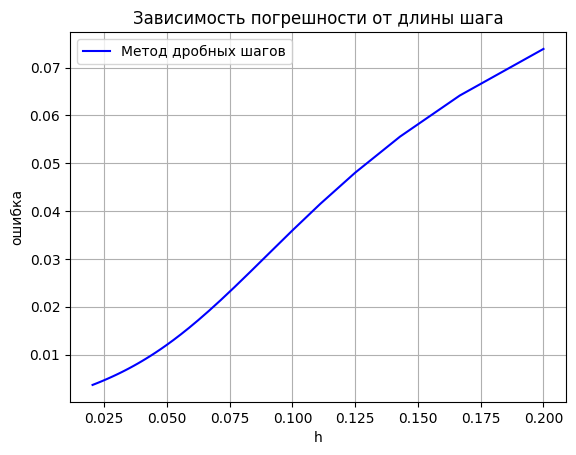

In [9]:
error_plot(method="MFS", method_name="Метод дробных шагов")

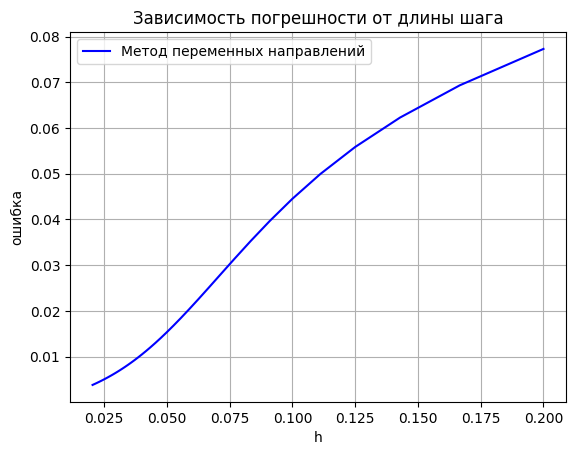

In [10]:
error_plot(method="MVD", method_name="Метод переменных направлений")

In [11]:
def method_plot(method, method_name, time=15, mu=[1.0,1.0], a=1.0):
    x_end = math.pi / (2 * mu[0])
    y_end = math.pi / (2 * mu[1])
    X_e, Y_e, T_e, Z_e = finite_difference_scheme(x_end=x_end, y_end=y_end, mu=mu, a=a, method=method)
    z_plot = []
    for j in range(0, len(X_e), 1):
        tmp = []
        for i in range(0, len(X_e[j]), 1):
            tmp.append(analytical_solution(X_e[j][i], Y_e[j][i], T_e[time], mu, a))
        z_plot.append(tmp)

    fig, axs = plt.subplots(1, 2, figsize=(16, 12), subplot_kw=dict(projection='3d'))
    axs[0].scatter(X_e, Y_e, Z_e[time], label=method_name, c='b')
    axs[0].scatter(X_e, Y_e, z_plot, label="Аналитическое", c='r')
    axs[1].scatter(X_e, Y_e, np.array(z_plot) - np.array(Z_e[time]))
    
    axs[0].legend()
    axs[0].grid()
    axs[1].grid()
    axs[0].set_title("Значения функций")
    axs[1].set_title("Погрешность")

    print("RMSE = ", RMSE(X_e, Y_e, T_e[time], Z_e[time], analytical_solution, mu, a))

RMSE =  0.006099053032781177


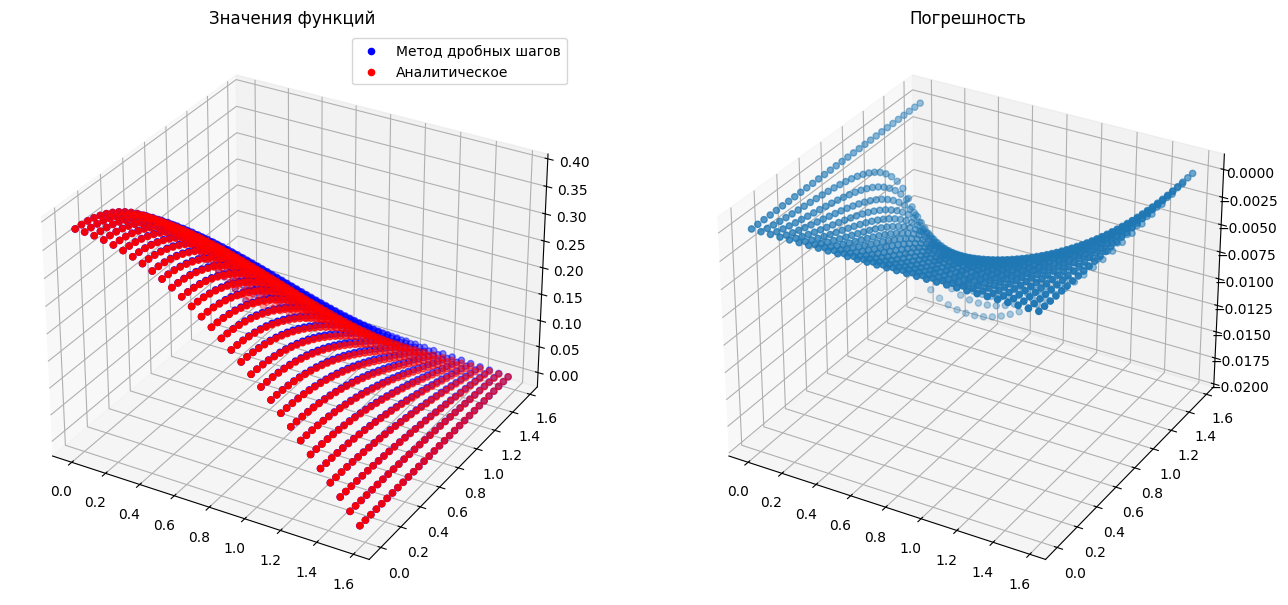

In [12]:
method_plot(method="MFS", method_name="Метод дробных шагов", mu=[1,1])

RMSE =  0.005857137441430975


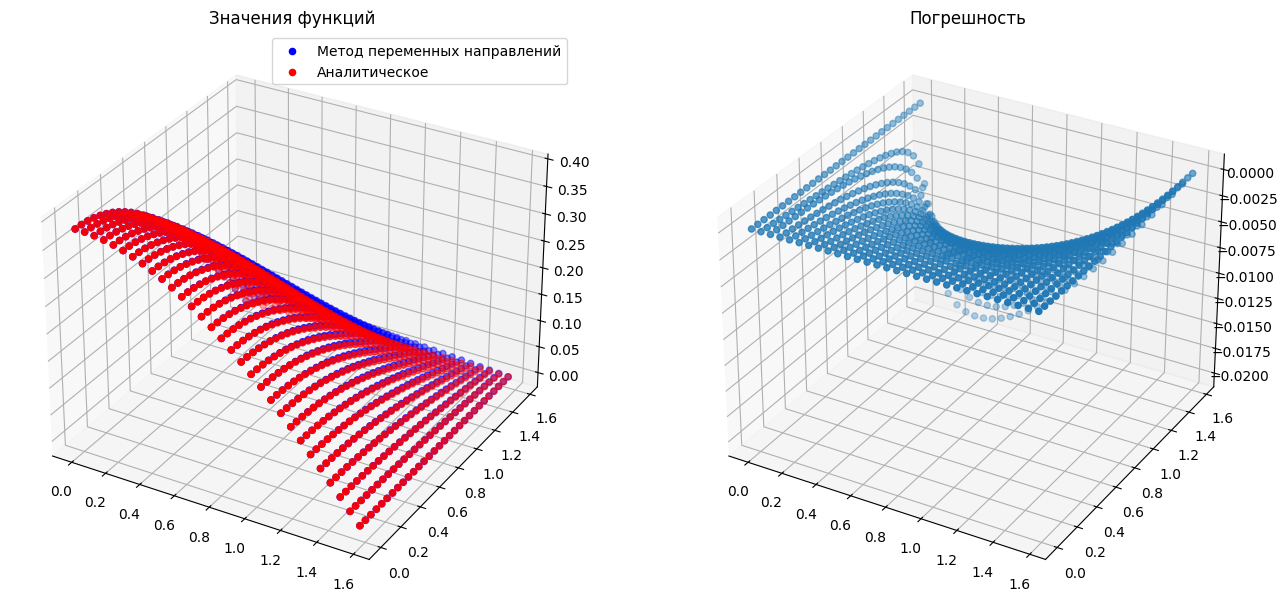

In [13]:
method_plot(method="MVD", method_name="Метод переменных направлений", mu=[1,1])

RMSE =  0.0021403179780050425


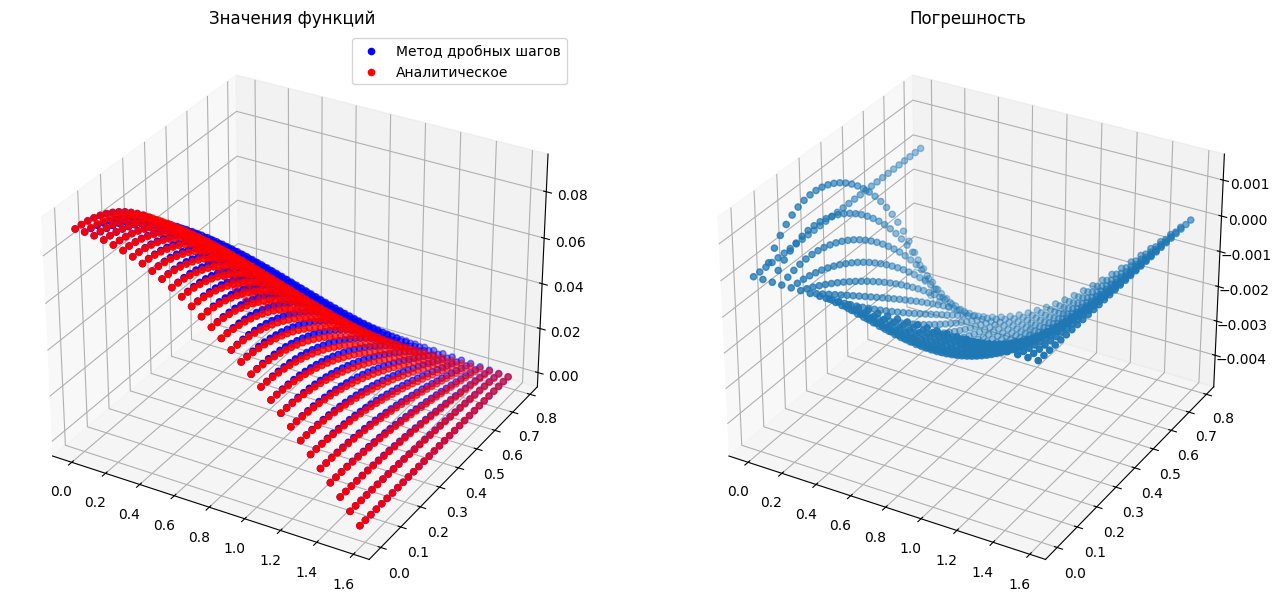

In [14]:
method_plot(method="MFS", method_name="Метод дробных шагов", mu=[1,2])

RMSE =  0.001870104221850973


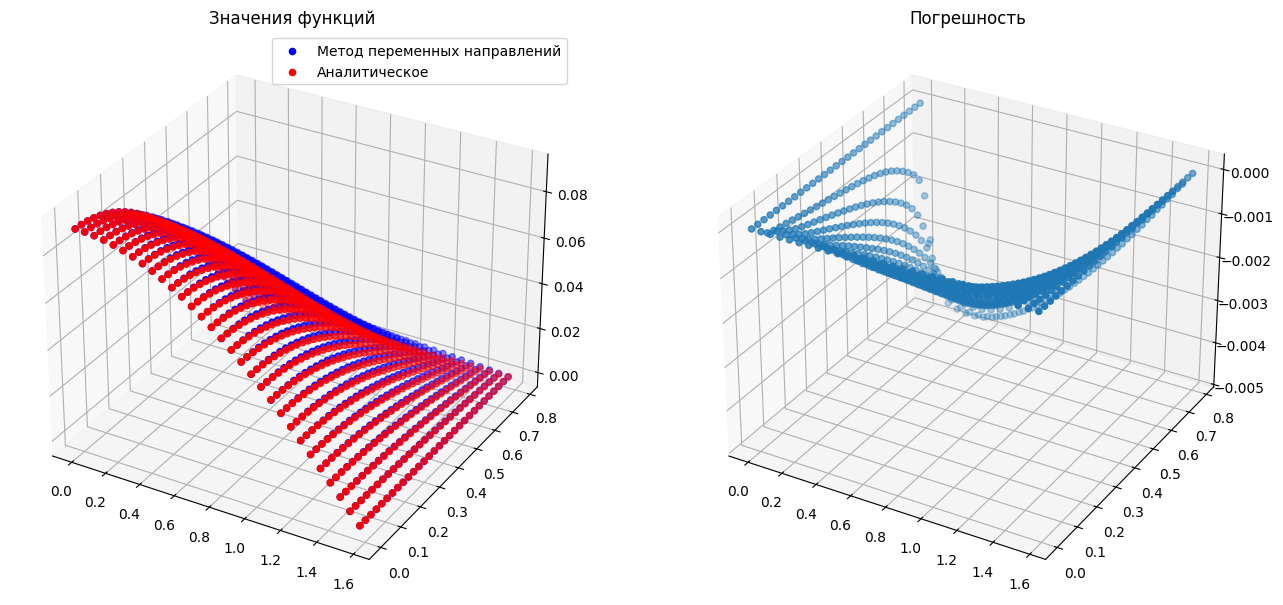

In [15]:
method_plot(method="MVD", method_name="Метод переменных направлений", mu=[1,2])

RMSE =  0.0027167228302709934


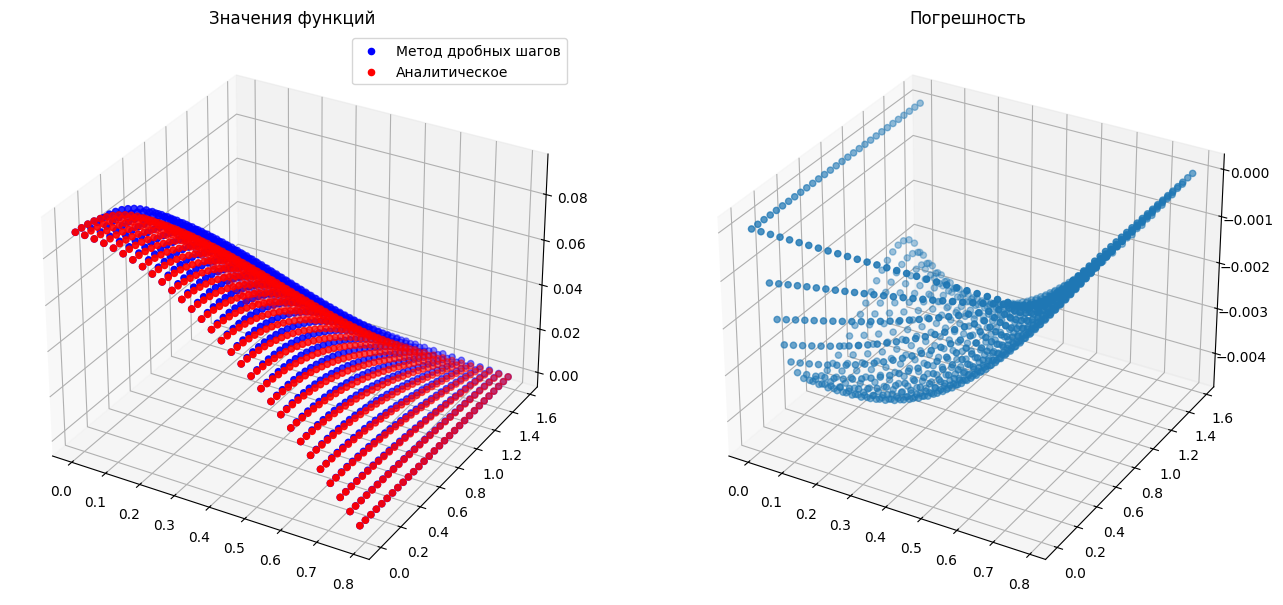

In [16]:
method_plot(method="MFS", method_name="Метод дробных шагов", mu=[2,1])

RMSE =  0.003017388605888459


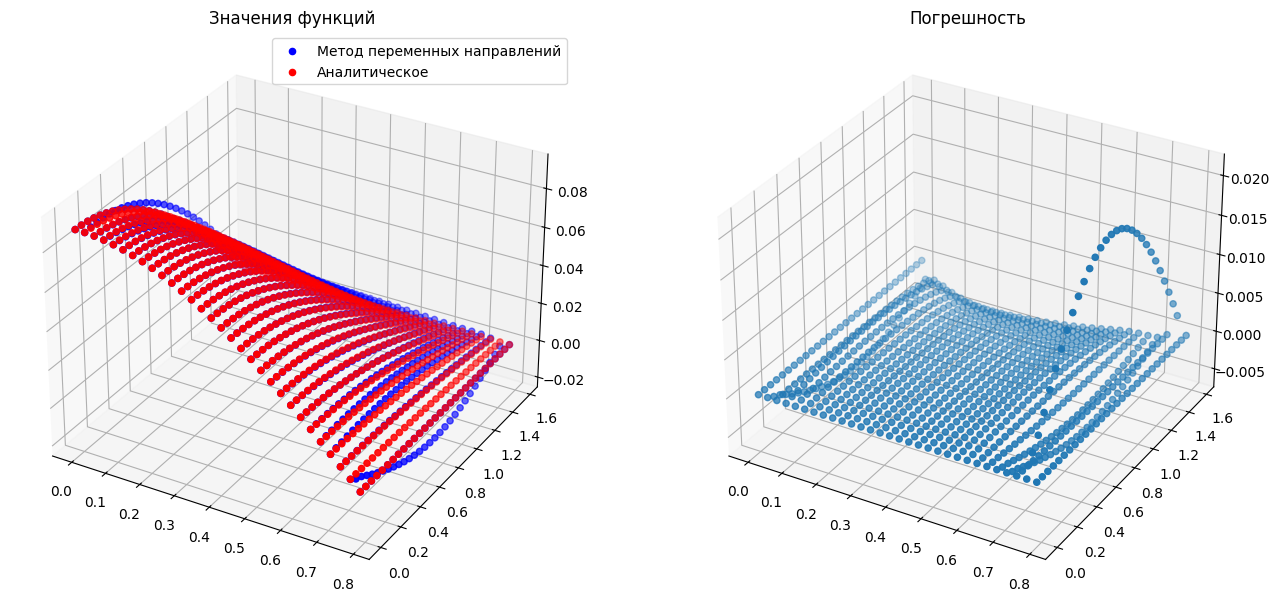

In [17]:
method_plot(method="MVD", method_name="Метод переменных направлений", mu=[2,1])